# Survive your commuting
INTRO: data from 1979 to 2015 etc.

## To do:
+ Explore data and deal with Nan values, outsanding values etc
+ Check whether we can work with all periodes (in terms of volume of data + consistency between datasets ?)
+ Categorize features (date, position etc.) and choose relevant ones (nice and easy to use + information)
+ Turn data into a format we can work with (dummy variables, easy to visualize, date format etc.)
+ function which returns the categorical value of dummified value

## Somes questions we can answer:
+ Accident per age and gender (cliché: young, men)
+ Casualties per age  and gender(cliché: children & elderlies)
+ Weather and road conditions dependency
+ passenger: safest place ? ou la place du mort (cars and bus)
+ home area type: accidents at home or in different area ? (citadins duper à la campagne et vice versa)
+ dates linked to special events etc.

+ nice viz (maps vith every accidents (comme pour la dataset français))

In [1]:
#import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import folium.plugins

In [2]:
#Global
DATA_FOLDER0514 = './data/Stats19_Data_2005-2014/'
DATA_FOLDER7904 = './data/Stats19-Data1979-2004/'

#columns we want to extract from the accidents file
acc_cols = [#Space and time context
            'Date','Time', 'Longitude', 'Latitude','Day_of_Week',
            #Identifier
            'Accident_Index', 
            #Police force related
            'Police_Force', 'Local_Authority_(District)', 'Local_Authority_(Highway)','Did_Police_Officer_Attend_Scene_of_Accident',
            #Casualties
            'Accident_Severity', 'Number_of_Casualties','Number_of_Vehicles',
            #Road conditions and traffic signalisations
            '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
            '2nd_Road_Class', '2nd_Road_Number',
            #Pedestrian 
            'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
            #Visibility and road conditions
            'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',
            'Urban_or_Rural_Area', 
            #'Location_Easting_OSGR','Location_Northing_OSGR', 'LSOA_of_Accident_Location',
           ]

#features legends
LEGENDS = pd.read_excel(DATA_FOLDER7904 + 'Road-Accident-Safety-Data-Guide-1979-2004.xls',
                        sheet_name = None,
                       )

In [3]:
#HELPERS

#TO DO: colors set (la c'est pas beau), remplacer les numéros de jours par les vrais jours
def plot_distrib(acc, group = "Day_of_Week", colname = "Accident_Index", ax = None):
    """
    Plot the distribution of colname per group
    """
    if colname == 'Accident_Index':
        acc[acc[group] != -1].groupby([group])[colname].count().plot.bar(x = group, 
                                                       y = colname,
                                                       title = colname + ' distribution per '+ group +', 0514',
                                                       ax = ax)
    else:
        acc[acc[group] != -1].groupby([group])[colname].sum().plot.bar(x = group, 
                                                     y = colname,
                                                     title = colname + ' distribution per '+ group +', 0514',
                                                     ax = ax)                        


In [70]:
#load data
if True:
    accidents = pd.read_csv(DATA_FOLDER0514 + "Accidents0514.csv",
                            index_col='Accident_Index',
                            parse_dates=['Date'],
                            dayfirst=True,
                            infer_datetime_format=True,
                            usecols = acc_cols)

    casualties = pd.read_csv(DATA_FOLDER0514 + "Casualties0514.csv")

years = np.arange(2005, 2015)
accidents['Casualties'] = casualties.groupby('Accident_Index').count()['Casualty_Reference']

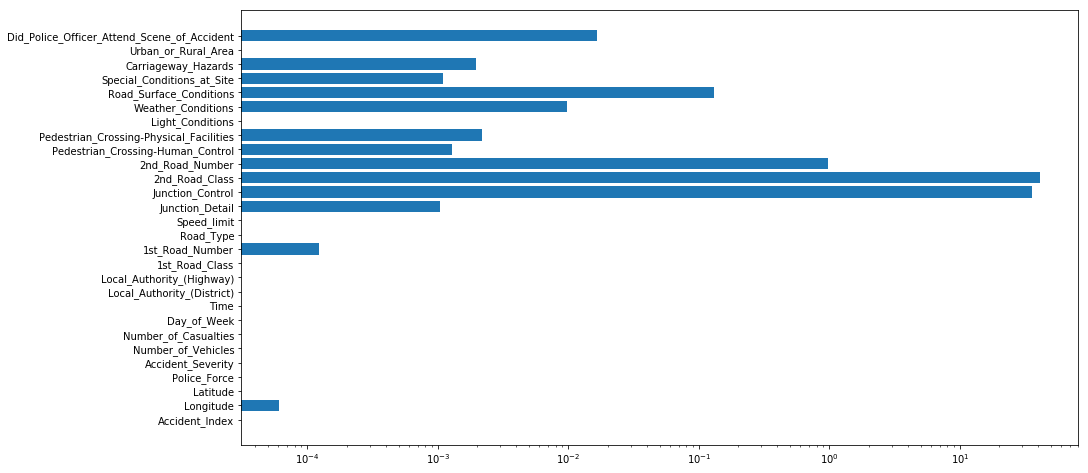

In [44]:
# Cleaning the dataset
percentage_of_nan = {}
columns = [col for col in accidents.columns if not col == 'Date']
for col in columns:
    percentage_of_nan[col] = (accidents[col] == -1 + accidents[col].isnull()).sum() / len(accidents) * 100
x = np.arange(len(percentage_of_nan))
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.barh(x, list(percentage_of_nan.values()), tick_label=list(percentage_of_nan.keys()), log=True);

> This plot show that rows are mostly complete. Some columns are full of missing values but it is mostly meaningfull (e.g. there isn't always a second road if the accident did not take place at an intersection).
The most important columns (Latitude and longitude) have only few missing values. We remove them.

In [8]:
accidents = accidents[accidents.Latitude.notnull() & accidents.Longitude.notnull()]

> We know that the names of the legends do not fit the name of the features, we need to replace whitespace by underscore.

In [9]:
#modify legend names to match with df features
for k in [k for k in LEGENDS.keys()]:
    LEGENDS[k.replace(' ', '_')] = LEGENDS.pop(k)

LEGENDS.keys()

odict_keys(['Introduction', 'Export_Variables', 'Police_Force', 'Accident_Severity', 'Day_of_Week', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Ped_Cross_-_Human', 'Ped_Cross_-_Physical', 'Light_Conditions', 'Weather', 'Road_Surface', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_Rural', 'Police_Officer_Attend', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Veh_Leaving_Carriageway', 'Hit_Object_Off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive', 'Journey_Purpose', 'Sex_of_Driver', 'Age_Band', 'Vehicle_Propulsion_Code', 'Casualty_Class', 'Sex_of_Casualty', 'Casualty_Severity', 'Ped_Location', 'Ped_Movement', 'Car_Passenger', 'Bus_Passenger', 'Ped_Road_Maintenance_Worker', 'Casualty_Type', 'IMD_Decile', 'Home_Area_Type'])

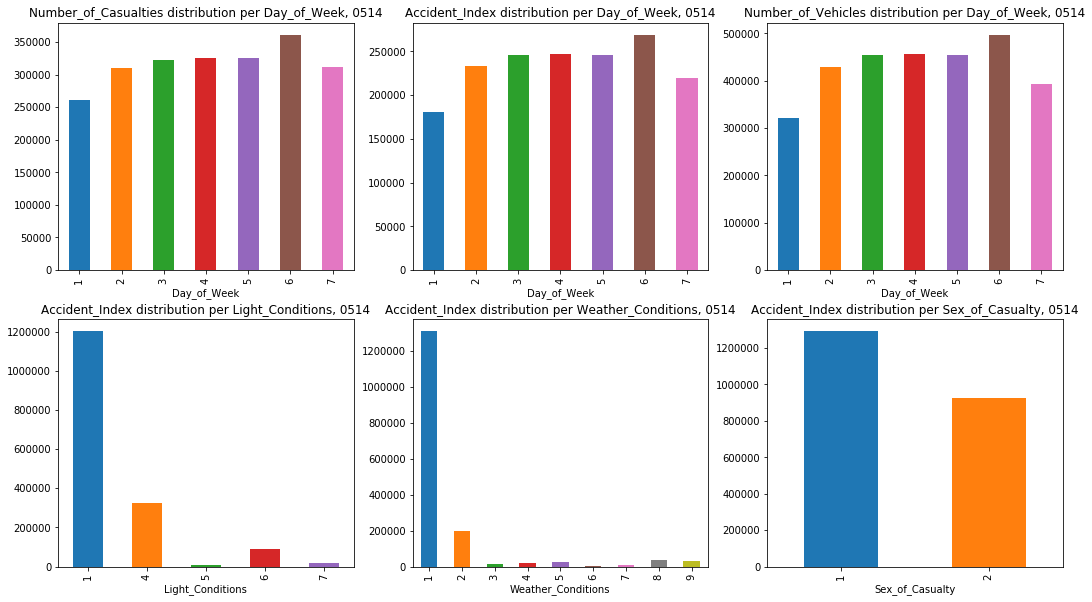

In [41]:
#Weekly distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plot_distrib(accidents, colname = "Number_of_Casualties", ax = axes[0][0])
plot_distrib(accidents, ax = axes[0][1])
plot_distrib(accidents, colname = "Number_of_Vehicles", ax = axes[0][2])
plot_distrib(accidents, group = "Light_Conditions", ax = axes[1][0])
plot_distrib(accidents, group = "Weather_Conditions", ax = axes[1][1])
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[1][2])

> Almost the same distri for the week. But Sunday is the lowest (people are doing nothing at home ?) and Friday is the worst (end of week = tired + party + départ en we ?)

> Plus de  blessés mais moins de véhicules le Dimanche que le Lundi, car le Dimanche = voiture en famille aka moins de voitures alors que Lundi = commute = tout seul dans sa caisse

> On va avoir besoin de diviser par la fréquence de chaque conditions => besoin de plus de données

> ce serait stylé d'avoir une couleur par jour, qui ne change pas

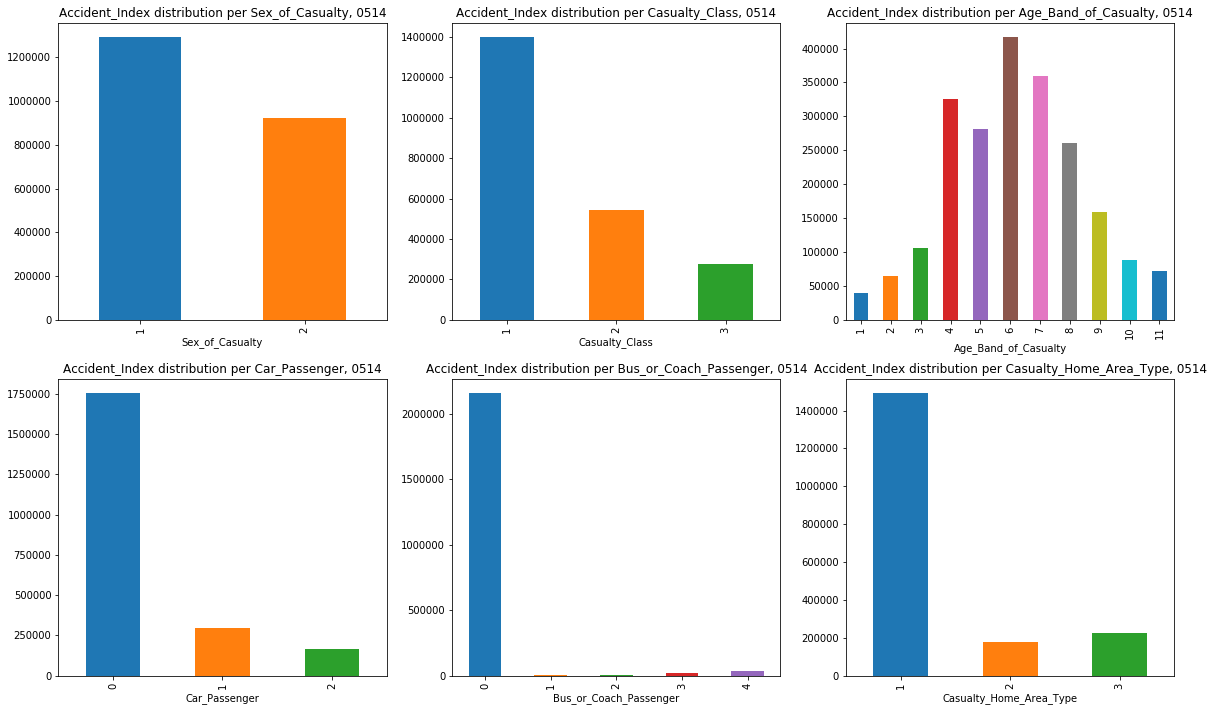

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[0][0])
plot_distrib(casualties, group = "Casualty_Class", ax = axes[0][1])
plot_distrib(casualties, group = "Age_Band_of_Casualty", ax = axes[0][2])
plot_distrib(casualties, group = "Car_Passenger", ax = axes[1][0])
plot_distrib(casualties, group = "Bus_or_Coach_Passenger", ax = axes[1][1])
plot_distrib(casualties, group = "Casualty_Home_Area_Type", ax = axes[1][2])


>Get rid of 0 for car_passenger and bus_passenger

In [37]:
london_coord = [55.3780518, -3.4359729]

In [35]:
# Plot every accidents in the UK from 2005 to 2014
m = folium.Map(location=london_coord, zoom_start=5)
marker_cluster = folium.plugins.marker_cluster.MarkerCluster().add_to(m)
for acc in accidents.sample(10000).itertuples():
    folium.Marker([acc.Latitude, acc.Longitude]).add_to(marker_cluster)
m

In [24]:
# Plot the approximate density of accidents in the UK
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMap(accidents[['Latitude', 'Longitude']].sample(1000).values).add_to(m)
m

In [34]:
# Plot the approximate density of accidents in the UK year per year
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMapWithTime([accidents[['Latitude', 'Longitude']][accidents.Date.dt.year == y].sample(1000).values.tolist()
                                for y in years]).add_to(m)
m

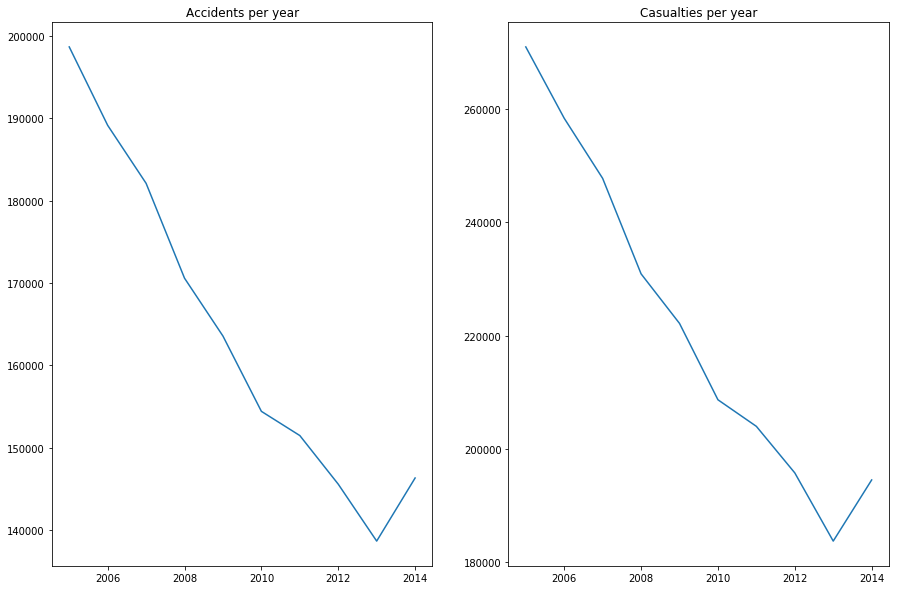

In [125]:
# Plot casualties per year, we expect a decrease
accidents_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .count()['Longitude']
casualties_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .agg({'Casualties': 'sum'})
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 10))
ax1.plot(years, accidents_per_year.groupby('Date').sum().values)
ax1.set_title("Accidents per year")
ax2.plot(years, casualties_per_year.groupby('Date').sum().values)
ax2.set_title("Casualties per year");

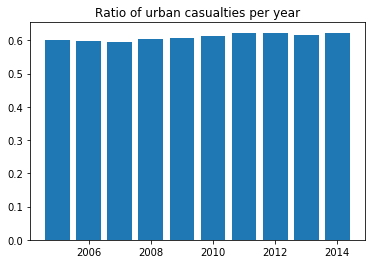

In [135]:
# Plot the ratio of urban casualties
plt.bar(years, [casualties_per_year.loc[y, 1][0] / (casualties_per_year.loc[y, 1][0] + casualties_per_year.loc[y, 2][0]) for y in years])
plt.title("Ratio of urban casualties per year");

Longitude  Latitude  Police_Force  \
Date Urban_or_Rural_Area                                      
2005 1                       126378    126378        126378   
     2                        72267     72267         72267   
     3                           21        21            90   
2006 1                       119841    119841        119841   
     2                        69293     69293         69293   
     3                           10        10            27   
2007 1                       114542    114542        114542   
     2                        67554     67554         67558   
     3                            4         4            15   
2008 1                       108589    108589        108589   
     2                        61991     61991         61991   
     3                            1         1            11   
2009 1                       104538    104538        104538   
     2                        59016     59016         59016   
2010 1                        99488     99488         99488   
     2                        54926     54926         54926   
2011 1                        99324     99324         99324   
     2                        52150     52150         52150   
2012 1                        95354     95354         95354   
     2                        50217     50217         50217   
2013 1                        90000     90000         90000   
     2                        48660     48660         48660   
2014 1                        96287     96287         96287   
     2                        50035     50035         50035   

                          Accident_Severity  Number_of_Vehicles  \
Date Urban_or_Rural_Area                                          
2005 1                               126378              126378   
     2                                72267               72267   
     3                                   90                  90   
2006 1                               119841              119841   
     2                                69293               69293   
     3                                   27                  27   
2007 1                               114542              114542   
     2                                67558               67558   
     3                                   15                  15   
2008 1                               108589              108589   
     2                                61991               61991   
     3                                   11                  11   
2009 1                               104538              104538   
     2                                59016               59016   
2010 1                                99488               99488   
     2                                54926               54926   
2011 1                                99324               99324   
     2                                52150               52150   
2012 1                                95354               95354   
     2                                50217               50217   
2013 1                                90000               90000   
     2                                48660               48660   
2014 1                                96287               96287   
     2                                50035               50035   

                          Number_of_Casualties    Date  Day_of_Week    Time  \
Date Urban_or_Rural_Area                                                      
2005 1                                  126378  126378       126378  126360   
     2                                   72267   72267        72267   72256   
     3                                      90      90           90      90   
2006 1                                  119841  119841       119841  119832   
     2                                   69293   69293        69293   69284   
     3                                      27      27           27      27   
2007 1      